In [1]:
import numpy as np
import pandas as pd

In [8]:
def alpha_optimize_perc(method,alphas,filesScore,filesPercs,namesCols,nSims = 100000,weighted = True):
    # intializing two vectors to store results
    score_perc_total = np.zeros(len(alphas))
    score_perc_S2 = np.zeros(len(alphas))
    indexer = 0
    
    # iterating over all alphas
    for alpha_try in alphas:
        
        if(alpha_try >= .8):
            nSims_use = nSims
        else:
            nSims_use = 5000
        
        # initializing the two correlations
        mc_perc_score = 0
        
        # intializing a vector to get each percentage (for getting a standard deviation)
        sd_vect = np.zeros(len(filesScore) - 1)
        
        # iterating over all years (we lose a year since we don't have anything 
        # to regress the 2019 data on)
        for year_of_data in np.arange(len(filesScore) - 1):
            
            # reading in the data
            data = pd.read_csv(filesScore[year_of_data],index_col=0)
            stats1 = pd.read_csv(filesPercs[year_of_data],index_col=0)
            stats2 = pd.read_csv(filesPercs[year_of_data + 1],index_col=0)
            # converting to a numpy array
            data2 = np.array(data)
            
            if(weighted == False):
                data2[data2!=0] = 1
            
            # making the Pij matrix
            Pij = data2/data2.sum(axis=0)
            
            # If we want the teleportation probabilties unifrom,
            # or based on team winning perc
            if method == 0:
                # making the teleporting probabilities uniform
                v = np.ones(32)/32
                v = v[np.newaxis]
                v = v.T
                # Setting alpha
                alpha = alpha_try
                # Setting eT
                eT = np.ones(32)[np.newaxis]   
            else:
                # making the teleporting probabilities proportional to
                # the teams winning percentages
                v = np.array(stats1[namesCols[year_of_data]])
                v = v[np.newaxis]
                v = v.T
                v = v/np.sum(v)
                # Setting alpha
                alpha = alpha_try
                # Setting eT
                eT = np.ones(32)[np.newaxis]
                
            # initializing our first guess
            x0 = np.ones(32)/32
            x0 = x0[np.newaxis]
            x0 = x0.T
            
            # performing the simulation
            for i in range(nSims_use):
                x0 = alpha*np.dot(Pij,x0) + (1-alpha)*v

            # defining the team names
            team_names = np.array(data.columns.get_values())
            
            # ordering the team's by their score
            mask = np.argsort(np.squeeze(x0))[::-1]
            x0_df = np.squeeze(x0[mask])
            team_names_df = team_names[mask]
            
            # forming a data frame
            teamrank = {'Team': team_names_df, 'score': x0_df, 'wins': 32*16/2*x0_df}
            teamrank_df = pd.DataFrame(data=teamrank)
            
            output = pd.merge(teamrank_df,
                  stats1,
                  left_on = "Team",
                  right_on = "team",
                  how = "inner")

            output = pd.merge(output,
                  stats2,
                  left_on = "Team",
                  right_on = "team",
                  how = "inner")
            
            # Figuring out ranks
            output['rank1'] = output[namesCols[year_of_data]].rank(ascending = False)
            output['rank2'] = output[namesCols[year_of_data + 1]].rank(ascending = False)
            
            # Computing the percent change correct
            score_rank = np.arange(32) + 1
            rank1 = np.array(output["rank1"])
            rank2 = np.array(output["rank2"])
            
            perc_correct = np.sum(np.logical_and(rank1 > rank2,rank1 > score_rank))/32 + \
                           np.sum(np.logical_and(rank1 < rank2,rank1 < score_rank))/32 + \
                           np.sum(np.logical_and(rank1 == rank2,rank1 == score_rank))/32
            
            # Storing the results
            mc_perc_score += perc_correct
            sd_vect[year_of_data] = perc_correct
            
        # Updating the percentages
        score_perc_total[indexer] = mc_perc_score/(len(filesScore) - 1)
        score_perc_S2[indexer] = np.std(sd_vect)/np.sqrt(len(filesScore) - 1)
        indexer += 1
        
    return score_perc_total,score_perc_S2

In [4]:
def data_chop(data,method,cutoff):
    # Method zero corresponds to eliminating close games
    if method == 0:
        # getting rid of the games below the cutoff
        data_np = np.array(data)
        data_np[data_np<=cutoff] = 0
        # Ensuring that if the jth column equals zero now, the j,jth entry is equal to zero
        if len(np.where(data_np.sum(axis = 0) == 0)[0]) > 0:
            empty_vect = np.where(data_np.sum(axis = 0) == 0)[0]
            for iCnt in range(len(empty_vect)):
                data_np[empty_vect[iCnt],empty_vect[iCnt]] = 1

        data_new = pd.DataFrame(data = data_np, columns = list(data)) 
    if method == 1:
        # getting rid of the games below the cutoff
        data_np = np.array(data)
        data_np[data_np>=cutoff] = cutoff
        data_new = pd.DataFrame(data = data_np, columns = list(data)) 
    return data_new

In [7]:
def alpha_optimize_perc_OUTLIER(method,alphas,filesScore,filesPercs,namesCols, method2,cutoff,
                               nSims = 10000,weighted = True):
    # intializing two vectors to store results
    score_perc_total = np.zeros(len(alphas))
    score_perc_S2 = np.zeros(len(alphas))
    indexer = 0
    
    # iterating over all alphas
    for alpha_try in alphas:
        
        if(alpha_try >= .8):
            nSims_use = nSims
        else:
            nSims_use = 5000
        
        # initializing the two correlations
        mc_perc_score = 0
        
        # intializing a vector to get each percentage (for getting a standard deviation)
        sd_vect = np.zeros(len(filesScore) - 1)
        
        # iterating over all years (we lose a year since we don't have anything 
        # to regress the 2019 data on)
        for year_of_data in np.arange(len(filesScore) - 1):
            
            # reading in the data
            data = pd.read_csv(filesScore[year_of_data],index_col=0)
            
            data_new = data_chop(data,method2,cutoff)
            
            
            stats1 = pd.read_csv(filesPercs[year_of_data],index_col=0)
            stats2 = pd.read_csv(filesPercs[year_of_data + 1],index_col=0)
            # converting to a numpy array
            data2 = np.array(data_new)
            
            if(weighted == False):
                data2[data2!=0] = 1
            
            # making the Pij matrix
            Pij = data2/data2.sum(axis=0)
            
            # If we want the teleportation probabilties unifrom,
            # or based on team winning perc
            if method == 0:
                # making the teleporting probabilities uniform
                v = np.ones(32)/32
                v = v[np.newaxis]
                v = v.T
                # Setting alpha
                alpha = alpha_try
                # Setting eT
                eT = np.ones(32)[np.newaxis]   
            else:
                # making the teleporting probabilities proportional to
                # the teams winning percentages
                v = np.array(stats1[namesCols[year_of_data]])
                v = v[np.newaxis]
                v = v.T
                v = v/np.sum(v)
                # Setting alpha
                alpha = alpha_try
                # Setting eT
                eT = np.ones(32)[np.newaxis]
                
            # initializing our first guess
            x0 = np.ones(32)/32
            x0 = x0[np.newaxis]
            x0 = x0.T
            
            # performing the simulation
            for i in range(nSims_use):
                x0 = alpha*np.dot(Pij,x0) + (1-alpha)*v

            # defining the team names
            team_names = np.array(data.columns.get_values())
            
            # ordering the team's by their score
            mask = np.argsort(np.squeeze(x0))[::-1]
            x0_df = np.squeeze(x0[mask])
            team_names_df = team_names[mask]
            
            # forming a data frame
            teamrank = {'Team': team_names_df, 'score': x0_df, 'wins': 32*16/2*x0_df}
            teamrank_df = pd.DataFrame(data=teamrank)
            
            output = pd.merge(teamrank_df,
                  stats1,
                  left_on = "Team",
                  right_on = "team",
                  how = "inner")

            output = pd.merge(output,
                  stats2,
                  left_on = "Team",
                  right_on = "team",
                  how = "inner")
            
            # Figuring out ranks
            output['rank1'] = output[namesCols[year_of_data]].rank(ascending = False)
            output['rank2'] = output[namesCols[year_of_data + 1]].rank(ascending = False)
            
            # Computing the percent change correct
            score_rank = np.arange(32) + 1
            rank1 = np.array(output["rank1"])
            rank2 = np.array(output["rank2"])
            
            perc_correct = np.sum(np.logical_and(rank1 > rank2,rank1 > score_rank))/32 + \
                           np.sum(np.logical_and(rank1 < rank2,rank1 < score_rank))/32 + \
                           np.sum(np.logical_and(rank1 == rank2,rank1 == score_rank))/32
            
            # Storing the results
            mc_perc_score += perc_correct
            sd_vect[year_of_data] = perc_correct
            
        # Updating the percentages
        score_perc_total[indexer] = mc_perc_score/(len(filesScore) - 1)
        score_perc_S2[indexer] = np.std(sd_vect)/np.sqrt(len(filesScore) - 1)
        indexer += 1
        
    return score_perc_total,score_perc_S2

In [9]:
# method
alphas = np.linspace(.025,.95,30)
filesScore = ["Pij_2009.csv","Pij_2010.csv",
              "Pij_2011.csv","Pij_2012.csv",
              "Pij_2013.csv","Pij_2014.csv",
              "Pij_2015.csv","Pij_2016.csv",
              "Pij_2017.csv","Pij_2018.csv"]

filesPercs = ["2009_win_perc.csv","2010_win_perc.csv","2011_win_perc.csv","2012_win_perc.csv",
             "2013_win_perc.csv","2014_win_perc.csv","2015_win_perc.csv",
             "2016_win_perc.csv","2017_win_perc.csv","2018_win_perc.csv"]
namesCols = ["win_perc_2009","win_perc_2010","win_perc_2011","win_perc_2012",
            "win_perc_2013","win_perc_2014","win_perc_2015",
            "win_perc_2016","win_perc_2017","win_perc_2018"]

## Running it for unchanged data

In [10]:
score_perc0,score_perc_S20 = alpha_optimize_perc(0,alphas,filesScore,filesPercs,namesCols)

## Running it for Data chopped with wins abovea certain amount of points

In [12]:
score_perc1,score_perc_S21 = alpha_optimize_perc_OUTLIER(0,alphas,filesScore,filesPercs,namesCols,\
                                                         method2 = 1,cutoff = 20)

In [17]:
score_perc2,score_perc_S22 = alpha_optimize_perc_OUTLIER(0,alphas,filesScore,filesPercs,namesCols,\
                                                         method2 = 1,cutoff = 18)

In [19]:
score_perc3,score_perc_S23 = alpha_optimize_perc_OUTLIER(0,alphas,filesScore,filesPercs,namesCols,\
                                                         method2 = 1,cutoff = 16)

In [23]:
score_perc4,score_perc_S24 = alpha_optimize_perc_OUTLIER(0,alphas,filesScore,filesPercs,namesCols,\
                                                         method2 = 1,cutoff = 14)

In [38]:
score_perc5,score_perc_S25 = alpha_optimize_perc_OUTLIER(0,alphas,filesScore,filesPercs,namesCols,\
                                                         method2 = 1,cutoff = 12)

In [43]:
score_perc6,score_perc_S26 = alpha_optimize_perc_OUTLIER(0,alphas,filesScore,filesPercs,namesCols,\
                                                         method2 = 1,cutoff = 17)

In [45]:
score_perc7,score_perc_S27 = alpha_optimize_perc_OUTLIER(0,alphas,filesScore,filesPercs,namesCols,\
                                                         method2 = 1,cutoff = 19)

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

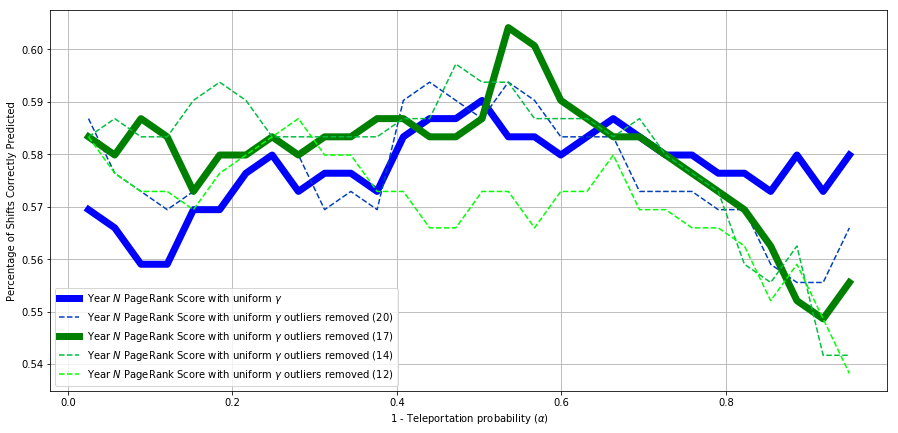

In [63]:
plt.figure(figsize=(15,7))

plt.plot(alphas,score_perc0,'b-',label = r'Year $N$ PageRank Score with uniform $\gamma$',color = (0, 0, 1),linewidth=7.0)
plt.plot(alphas,score_perc1,'r--',label = r'Year $N$ PageRank Score with uniform $\gamma$ outliers removed (20)',color = (0, .25, 0.75))
plt.plot(alphas,score_perc6,'g-',label = r'Year $N$ PageRank Score with uniform $\gamma$ outliers removed (17)',linewidth=7.0)
plt.plot(alphas,score_perc4,'r--',label = r'Year $N$ PageRank Score with uniform $\gamma$ outliers removed (14)',color = (0, .75, .25))
plt.plot(alphas,score_perc5,'r--',label = r'Year $N$ PageRank Score with uniform $\gamma$ outliers removed (12)',color = (0, 1, 0))

plt.xlabel(r'1 - Teleportation probability ($\alpha$)')
plt.ylabel("Percentage of Shifts Correctly Predicted")
plt.legend()
plt.grid()
plt.show()

# By Eliminating Close Games

In [56]:
score_perc8,score_perc_S28 = alpha_optimize_perc_OUTLIER(0,alphas,filesScore,filesPercs,namesCols,\
                                                         method2 = 0,cutoff = 3)

In [65]:
score_perc9,score_perc_S29 = alpha_optimize_perc_OUTLIER(0,alphas,filesScore,filesPercs,namesCols,\
                                                         method2 = 0,cutoff = 2)

In [66]:
score_perc10,score_perc_S210 = alpha_optimize_perc_OUTLIER(0,alphas,filesScore,filesPercs,namesCols,\
                                                         method2 = 0,cutoff = 1)

In [67]:
score_perc11,score_perc_S211 = alpha_optimize_perc_OUTLIER(0,alphas,filesScore,filesPercs,namesCols,\
                                                         method2 = 0,cutoff = 4)

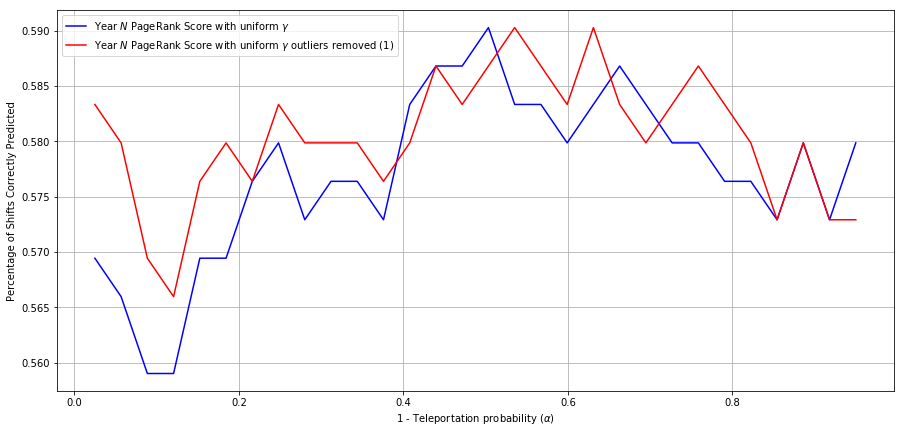

In [71]:
plt.figure(figsize=(15,7))

plt.plot(alphas,score_perc0,'b-',label = r'Year $N$ PageRank Score with uniform $\gamma$')
plt.plot(alphas,score_perc10,'r-',label = r'Year $N$ PageRank Score with uniform $\gamma$ outliers removed (1)')
plt.xlabel(r'1 - Teleportation probability ($\alpha$)')
plt.ylabel("Percentage of Shifts Correctly Predicted")
plt.legend()
plt.grid()
plt.show()

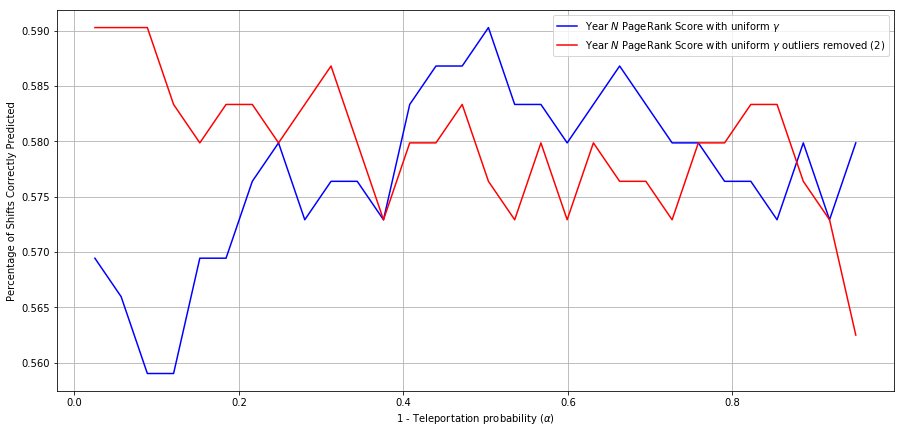

In [72]:
plt.figure(figsize=(15,7))

plt.plot(alphas,score_perc0,'b-',label = r'Year $N$ PageRank Score with uniform $\gamma$')
plt.plot(alphas,score_perc9,'r-',label = r'Year $N$ PageRank Score with uniform $\gamma$ outliers removed (2)')
plt.xlabel(r'1 - Teleportation probability ($\alpha$)')
plt.ylabel("Percentage of Shifts Correctly Predicted")
plt.legend()
plt.grid()
plt.show()

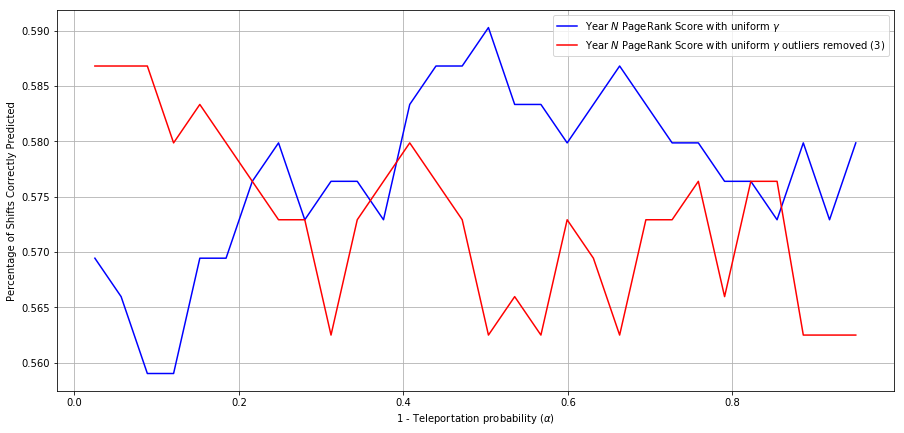

In [73]:
plt.figure(figsize=(15,7))

plt.plot(alphas,score_perc0,'b-',label = r'Year $N$ PageRank Score with uniform $\gamma$')
plt.plot(alphas,score_perc8,'r-',label = r'Year $N$ PageRank Score with uniform $\gamma$ outliers removed (3)')
plt.xlabel(r'1 - Teleportation probability ($\alpha$)')
plt.ylabel("Percentage of Shifts Correctly Predicted")
plt.legend()
plt.grid()
plt.show()